In [22]:
# load data from tsp file
import numpy as np

tsp_data = np.loadtxt('../TSPDataset/gr17.2085.tsp')
print(tsp_data.shape)

(17, 17)


In [23]:
import math
import queue

def initial_solution(length):
    s = np.random.choice(range(length), length, replace=False) # cities in [0,length]
    return s

def objectivefunction(s):
    cost = 0
    for i in range(s.shape[0]-1):
        cost = cost + tsp_data[s[i]][s[i+1]]
    cost = cost + tsp_data[s[-1]][s[0]]
    return cost

def pick_next_nontabu_neighbor(neighbors_list, tabu_list):
    # on cherche le premier voisin qui n'est pas dans la liste tabu
    for neighbor in neighbors_list:
        if not any((neighbor == tabu).all() for tabu in list(tabu_list.queue)):
            return neighbor
    # None si aucun voisin non-tabu n'est trouvé
    return None

def tabu_neighbor(s, tabu_list):
    # on veérifie si la solution s est présente dans la liste tabu
    
    for tabu in list(tabu_list.queue): # on parcourt tous les éléments de la liste tabu
        if (s == tabu).all(): # true si tous les éléments de s sont égaux à ceux de tabu
            return True
    return False

def generate_sorted_neighbors(s):
    # on génere tous les voisins de la solution actuelle en échangeant deux villes
    
    # on initilialise les listes des voisins et leurs coûts
    neighbors = []
    costs = []
    
    for i in range(len(s)): # on parcourt toutes les villes
        for j in range(i+1, len(s)): # on parcourt les villes suivantes pour échanger
            
            # ON crée un nouveau voisin en échangeant les villes aux indices i et j
            neighbor = np.copy(s)
            
            neighbor[i], neighbor[j] = neighbor[j], neighbor[i] # echanger les villes
            
            # on ajoute le voisin à la liste des voisins
            neighbors.append(neighbor)
            
            # calcul du coût du voisin
            costs.append(objectivefunction(neighbor))
            
    # on trie les voisins par leurs coûts en ordre croissant
    sorted_indices = np.argsort(costs)
    
    # on retourne les voisins et leurs coûts triés
    neighbors = [neighbors[i] for i in sorted_indices]
    costs = [costs[i] for i in sorted_indices]
    return neighbors, costs

def best_admessible_neighbor(s, tabu_list):
    # return sorted neighbors_list and associated costs
    neighbors_list, costs = generate_sorted_neighbors(np.copy(s))
    
    # les indices 0 contiennent le meilleur voisin
    best_neighbor, cost = neighbors_list[0], costs[0]
    
    # check if the best neighbor is a tabu
    tabu = tabu_neighbor(best_neighbor, tabu_list)
    
    if (cost < objectivefunction(s)):
        return best_neighbor, tabu
    else: # escape from local optimum by accepting a degraded solution
        if not tabu:
            return best_neighbor, tabu
        else: # pick non-tabu neighbor
            return pick_next_nontabu_neighbor(neighbors_list, tabu_list), False

In [24]:
import queue
import matplotlib.pyplot as plt

tabu_list = queue.Queue(5) # FIFO queue of 5 items max

costs_hist = []

# Random initial solution and its cost
length_s = 17
s = initial_solution(length_s) #np.random.choice(range(length_s), length_s, replace=False) #cities in [0,length_s]
cost_s = objectivefunction(s)

# Update tabu list
tabu_list.put(np.copy(s))

# Save history of costs
costs_hist.append(cost_s)

# Consider solution s as the best solution for now
best_s = np.copy(s) # hard copy
best_cost = cost_s

total_it = 0 # max iterations

while total_it < 100:
    adm_s, tabu = best_admessible_neighbor(np.copy(s), tabu_list)
    cost_adm_s = objectivefunction(adm_s)
    costs_hist.append(cost_adm_s)

    # update s
    s = np.copy(adm_s)

    if not tabu: # adm_s not satisfying an aspiration criterion
        # update best solution if necessary
        if cost_adm_s < best_cost: 
            best_s = np.copy(adm_s)
            best_cost = cost_adm_s

        # update tabu list by adding adm_s as a visited solution
        
        if not tabu_list.full():
            # on vérifie si la liste tabu n'est pas pleine car on ne peut pas ajouter plus de 5 éléments
            tabu_list.put(np.copy(adm_s))
        else:
            
            # si elle est pleine :on retire le premier élément de la liste tabu et on ajoute le nouvel élément
            tabu_list.get()
            tabu_list.put(np.copy(adm_s))

    total_it += 1 # increment iteration

print('best sol, cost {} {}'.format(best_s, best_cost))


best sol, cost [ 5  7  6 12  3  0 15 11  8  4  1  9 10  2 14 13 16] 2085.0


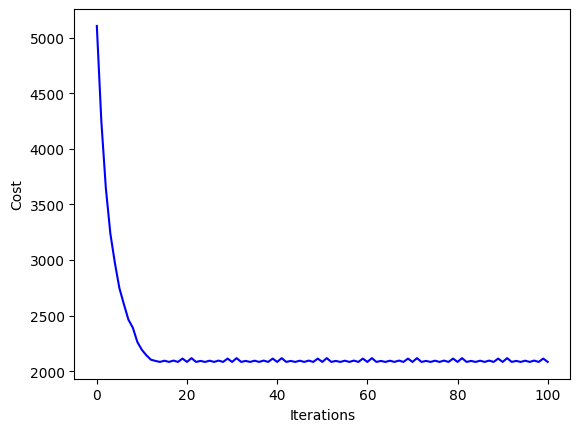

In [25]:
import matplotlib.pyplot as plt

plt.plot(costs_hist, 'b')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

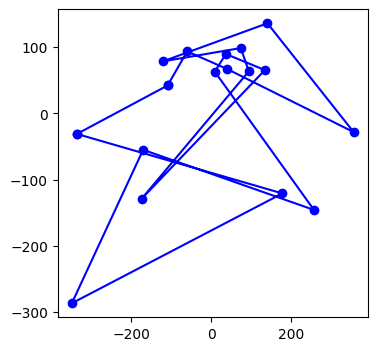

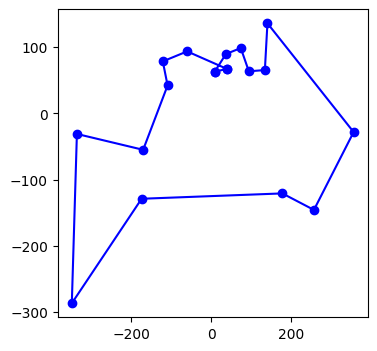

In [26]:
# convert distance matrix between cities into coordinates of cities 
from sklearn import manifold  # multidimensional scaling

mds_model = manifold.MDS(n_components=2, random_state=length_s,
                             dissimilarity='precomputed')
mds_fit = mds_model.fit(tsp_data)
mds_coords = mds_model.fit_transform(tsp_data)

# plot a random solution over cities
s = initial_solution(length_s)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot(mds_coords[s, 0], mds_coords[s, 1], 'b-o')
plt.plot([mds_coords[s[0], 0], mds_coords[s[-1], 0]],
         [mds_coords[s[0], 1], mds_coords[s[-1], 1]], 'b-o')


# plot the best solution over cities
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot(mds_coords[best_s, 0], mds_coords[best_s, 1], 'b-o')
plt.plot([mds_coords[best_s[0], 0], mds_coords[best_s[-1], 0]],
         [mds_coords[best_s[0], 1], mds_coords[best_s[-1], 1]], 'b-o')